# Imports

In [1]:
%matplotlib inline

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc     import imsave
from keras          import metrics
from vgg16_avg      import VGG16_Avg
from PIL            import Image

from keras.models   import Model

import keras.backend     as K
import numpy             as np
import matplotlib.pyplot as plt
import scipy.ndimage

Using TensorFlow backend.


# Data loading

First, we have to write a function that limits the memory Tensorflow is allowed to use.

In [2]:
def limit_mem():
    cfg                          = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config = cfg))

In [3]:
limit_mem()

Then we load our content and style image, convert them to numpy array and then apply the standard imagenet preprocessing.

In [4]:
#content_fn = '../data/pictures/dog_small.jpg'
content_fn = '../data/pictures/dog_02_small.jpg'
style_fn   = '../data/pictures/van_gogh.jpg'

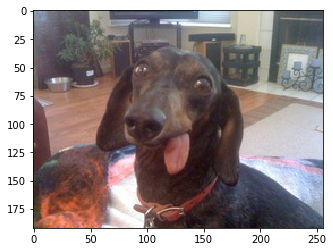

In [5]:
content       = Image.open(content_fn)
content_array = np.array(content)
plt.imshow(content_array)

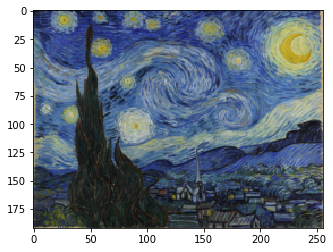

In [6]:
style       = Image.open(style_fn)
style_array = scipy.misc.imresize(style, content.size[::-1])
plt.imshow(style_array)

In [7]:
imagenet_component_mean = np.array([123.68, 116.779, 103.939], dtype = np.float32)

def imagenet_preproc(image_array):
    return (image_array - imagenet_component_mean)[:, :, :, ::-1]

def undo_imagenet_preproc(image_array, shape):
    return np.clip(image_array.reshape(shape)[:, :, :, ::-1] + imagenet_component_mean, 0, 255)

def plot_array(array):
    plt.imshow(undo_imagenet_preproc(array, array.shape)[0].astype('uint8'))

In [8]:
content_batch = np.expand_dims(content_array, 0)
content_shape = content_batch.shape
style_batch   = np.expand_dims(style_array, 0) 
style_shape   = style_batch.shape

In [9]:
content_batch = imagenet_preproc(content_batch)
style_batch   = imagenet_preproc(style_batch)

# Reconstructions

## Content reconstruction

To reconstruct the content of an image, we chose a convolutionnal layer in the VGG network and optimize a random image in order to get the same outputs as our content image for this layer.

In [10]:
model = VGG16_Avg(include_top = False)

In [11]:
for layer in model.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [12]:
content_layer = model.get_layer('block5_conv1').output

In [13]:
layer_model    = Model(model.input, content_layer)
content_target = K.variable(layer_model.predict(content_batch))

In [14]:
class Evaluator(object):
    def __init__(self, function, shape):
        self.function = function
        self.shape    = shape
        
    def loss(self, x):
        loss_, self.gradient_values = self.function([x.reshape(self.shape)])
        
        return loss_.astype(np.float64)
    
    def gradients(self, x):
        return self.gradient_values.flatten().astype(np.float64)

In [15]:
loss      = metrics.mse(content_layer, content_target)
gradients = K.gradients(loss, model.input)
fn        = K.function([model.input], [loss] + gradients)
evaluator = Evaluator(fn, content_shape)

In [16]:
def solve_image(evaluator, iteration_number, x):
    shape = x.shape
    for i in range(iteration_number):
        x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime = evaluator.gradients, maxfun = 20)
        
        x = np.clip(x, -127, 127)
        print('Current loss value:', min_val)
        imsave('../data/pictures/res_at_iteration_%02d.png' % i, undo_imagenet_preproc(x.copy(), shape)[0])
    return x

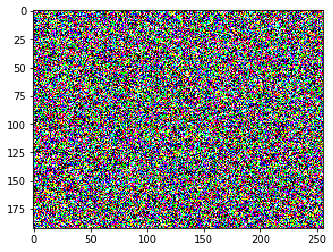

In [17]:
rand_image = lambda shape: np.random.uniform(-2.5, 2.5, shape) / 100
x          = rand_image(content_shape)
plt.imshow(x[0])

In [18]:
iteration_number = 10

In [19]:
x = solve_image(evaluator, iteration_number, x)

Current loss value: 59.3991165161
Current loss value: 23.0506153107
Current loss value: 14.3082580566
Current loss value: 9.66819763184
Current loss value: 7.100440979
Current loss value: 5.73499059677
Current loss value: 4.76871204376
Current loss value: 4.12379407883
Current loss value: 3.6945245266
Current loss value: 3.3324739933


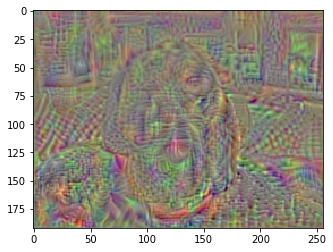

In [20]:
from IPython.display import HTML
from matplotlib      import animation, rc

fig, ax = plt.subplots()

def animate(i):
    ax.imshow(Image.open('../data/pictures/res_at_iteration_%02d.png' % i))

anim = animation.FuncAnimation(fig, animate, frames = 10, interval = 200)
HTML(anim.to_html5_video())

## Style reconstruction

In [21]:
model   = VGG16_Avg(include_top = False, input_shape = style_shape[1:])
outputs = {layer.name : layer.output for layer in model.layers} 

outputs

{'block1_conv1': <tf.Tensor 'Relu_13:0' shape=(?, 192, 256, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'Relu_14:0' shape=(?, 192, 256, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'AvgPool_5:0' shape=(?, 96, 128, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'Relu_15:0' shape=(?, 96, 128, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'Relu_16:0' shape=(?, 96, 128, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'AvgPool_6:0' shape=(?, 48, 64, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'Relu_17:0' shape=(?, 48, 64, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'Relu_18:0' shape=(?, 48, 64, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'Relu_19:0' shape=(?, 48, 64, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'AvgPool_7:0' shape=(?, 24, 32, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'Relu_20:0' shape=(?, 24, 32, 512) dtype=float32>,
 'block4_conv2': <tf.Tensor 'Relu_21:0' shape=(?, 24, 32, 512) dtype=float32>,
 'block4_conv3': <tf.Tensor 'Relu_22:0' shape

In [22]:
style_layers = [outputs['block%d_conv1' % block_number] for block_number in range(1, 3)]
style_layers

[<tf.Tensor 'Relu_13:0' shape=(?, 192, 256, 64) dtype=float32>,
 <tf.Tensor 'Relu_15:0' shape=(?, 96, 128, 128) dtype=float32>]

In [23]:
layers_model  = Model(model.input, style_layers)
style_targets = [K.variable(output) for output in layers_model.predict(style_batch)] 

In [24]:
def gram_matrix(x):
    # We want each row to be a channel and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [25]:
def style_loss(x, target):
    return metrics.mse(gram_matrix(x), gram_matrix(target))

In [26]:
loss      = sum(style_loss(l1[0], l2[0]) for l1, l2 in zip(style_layers, style_targets))
gradients = K.gradients(loss, model.input)
style_fn  = K.function([model.input], [loss] + gradients)
evaluator = Evaluator(style_fn, style_shape)

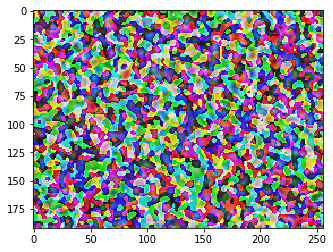

In [27]:
rand_image = lambda shape: np.random.uniform(-2.5, 2.5, shape) / 1
x          = rand_image(style_shape)
x          = scipy.ndimage.filters.gaussian_filter(x, [0, 2, 2, 0])
plt.imshow(x[0])

In [28]:
iteration_number = 10

In [29]:
x = solve_image(evaluator, iteration_number, x)

Current loss value: 2431.09155273
Current loss value: 139.624130249
Current loss value: 75.2694549561
Current loss value: 50.5142097473
Current loss value: 32.6721382141
Current loss value: 20.6118183136
Current loss value: 12.2168531418
Current loss value: 7.72926044464
Current loss value: 5.52198791504
Current loss value: 4.23543357849


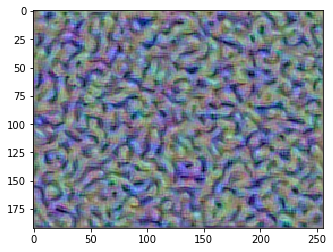

In [30]:
fig, ax = plt.subplots()

def animate(i):
    ax.imshow(Image.open('../data/pictures/res_at_iteration_%02d.png' % i))

anim = animation.FuncAnimation(fig, animate, frames = 10, interval = 200)
HTML(anim.to_html5_video())

# Style transfer

In [31]:
style_layers  = [outputs['block%d_conv2' % output] for output in range(1, 6)]
content_name  = 'block4_conv2'
content_layer = outputs[content_name]

In [32]:
style_model   = Model(model.input, style_layers)
style_targets = [K.variable(o) for o in style_model.predict(style_batch)]

In [33]:
content_model  = Model(model.input, content_layer)
content_target = K.variable(content_model.predict(content_batch))

In [34]:
style_weights = [0.05, 0.2, 0.2, 0.25, 0.3]

In [35]:
loss        = sum(style_loss(l1[0], l2[0]) * w for l1, l2, w in zip(style_layers, style_targets, style_weights))
loss        = loss + metrics.mse(content_layer, content_target) / 10
gradients   = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss] + gradients)

In [36]:
evaluator = Evaluator(transfer_fn, content_shape)

In [37]:
iterations = 50
x          = rand_image(content_shape)

In [38]:
x = solve_image(evaluator, iterations, x)

Current loss value: 3384.37402344
Current loss value: 702.154907227
Current loss value: 421.887359619
Current loss value: 335.182250977
Current loss value: 275.784973145
Current loss value: 236.302642822
Current loss value: 208.836105347
Current loss value: 188.406677246
Current loss value: 171.301620483
Current loss value: 159.705200195
Current loss value: 150.526412964
Current loss value: 142.973114014
Current loss value: 137.421386719
Current loss value: 133.250488281
Current loss value: 129.968444824
Current loss value: 126.885574341
Current loss value: 124.428619385
Current loss value: 122.370773315
Current loss value: 120.434417725
Current loss value: 118.850746155
Current loss value: 117.464179993
Current loss value: 116.308242798
Current loss value: 115.322006226
Current loss value: 114.422454834
Current loss value: 113.586669922
Current loss value: 112.848693848
Current loss value: 112.14540863
Current loss value: 111.436935425
Current loss value: 110.802635193
Current loss va

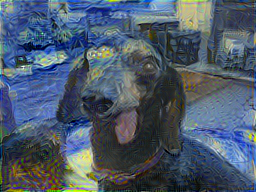

In [39]:
Image.open('../data/pictures/res_at_iteration_49.png')